In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Parameters
L = 2 * np.pi  # Domain size (circular domain)
N = 100  # Number of spatial points
T = 10.0  # Total simulation time
dt = 0.001  # Time step (reduced)
dx = L / N  # Spatial step

x = np.linspace(0, L, N)
t = np.arange(0, T, dt)

# Parameters for the PDEs (reduced some values)
alpha_1, alpha_2, alpha_3 = 0.1, 0.05, 0.08
K_1, K_2, K_3 = 1.0, 0.8, 0.6
r_v, r_m = 0.02, 0.01
r_d, r_dy = 0.001, 0.0005
r_n = 0.001
r_p1, r_p2 = 0.03, 0.02
r_c = 0.01

# Initialize populations
P = np.zeros((len(t), N))
V = np.zeros((len(t), N, N))  # V(y, v, t)
M = np.zeros((len(t), N))

# Initial conditions
P[0] = 0.5 + 0.1 * np.sin(x)
V[0] = 0.3 + 0.05 * np.sin(np.outer(x, x))
M[0] = 0.4 + 0.1 * np.cos(x)

def f(y, x):
    return 0.5 - np.exp(np.cos(y - x)) / (2 * np.pi * np.i0(1))

def safe_divide(a, b, fill_value=0.0):
    return np.divide(a, b, out=np.full_like(a, fill_value), where=b!=0)

def clip_values(arr, min_val=-1e6, max_val=1e6):
    return np.clip(arr, min_val, max_val)

def dP_dt(P, V, M):
    d2P_dx2 = np.gradient(np.gradient(P, dx, edge_order=2), dx, edge_order=2)
    
    integral_V = np.sum((r_v - np.linspace(0, 1, N)) * V * f(x[:, np.newaxis], x), axis=1) * dx
    integral_M = np.sum(M * f(x[:, np.newaxis], x), axis=1) * dx
    
    return clip_values(alpha_1 * P * (1 - P/K_1) + 
            P * integral_V + 
            r_m * P * integral_M + 
            r_d * d2P_dx2 + 
            r_n * P * np.random.normal(0, 1, N))

def dV_dt(P, V, M):
    d2V_dy2 = np.gradient(np.gradient(V, dx, axis=0, edge_order=2), dx, axis=0, edge_order=2)
    d2V_dv2 = np.gradient(np.gradient(V, dx, axis=1, edge_order=2), dx, axis=1, edge_order=2)
    
    integral_P = np.sum(P * f(x[:, np.newaxis], x), axis=1) * dx
    
    v_values = np.linspace(0, 1, N)
    return clip_values(alpha_2 * V * (1 - V/K_2) - 
            r_p1 * V * integral_P[:, np.newaxis] + 
            r_dy * (d2V_dy2 + d2V_dv2) + 
            r_n * V * np.random.normal(0, 1, V.shape) - 
            r_c * safe_divide(v_values, 1 - v_values))

def dM_dt(P, V, M):
    d2M_dy2 = np.gradient(np.gradient(M, dx, edge_order=2), dx, edge_order=2)
    
    integral_P = np.sum(P * f(x[:, np.newaxis], x), axis=1) * dx
    
    return clip_values(alpha_3 * M * (1 - M/K_3) - 
            r_p2 * M * integral_P + 
            r_d * d2M_dy2 + 
            r_n * M * np.random.normal(0, 1, N))

# Simulation
for n in range(1, len(t)):
    dP = dP_dt(P[n-1], V[n-1], M[n-1])
    dV = dV_dt(P[n-1], V[n-1], M[n-1])
    dM = dM_dt(P[n-1], V[n-1], M[n-1])
    
    P[n] = P[n-1] + dt * dP
    V[n] = V[n-1] + dt * dV
    M[n] = M[n-1] + dt * dM
    
    # Ensure populations remain non-negative
    P[n] = np.maximum(P[n], 0)
    V[n] = np.maximum(V[n], 0)
    M[n] = np.maximum(M[n], 0)

Text(0.5, 1.0, 'Mimic Population Density')

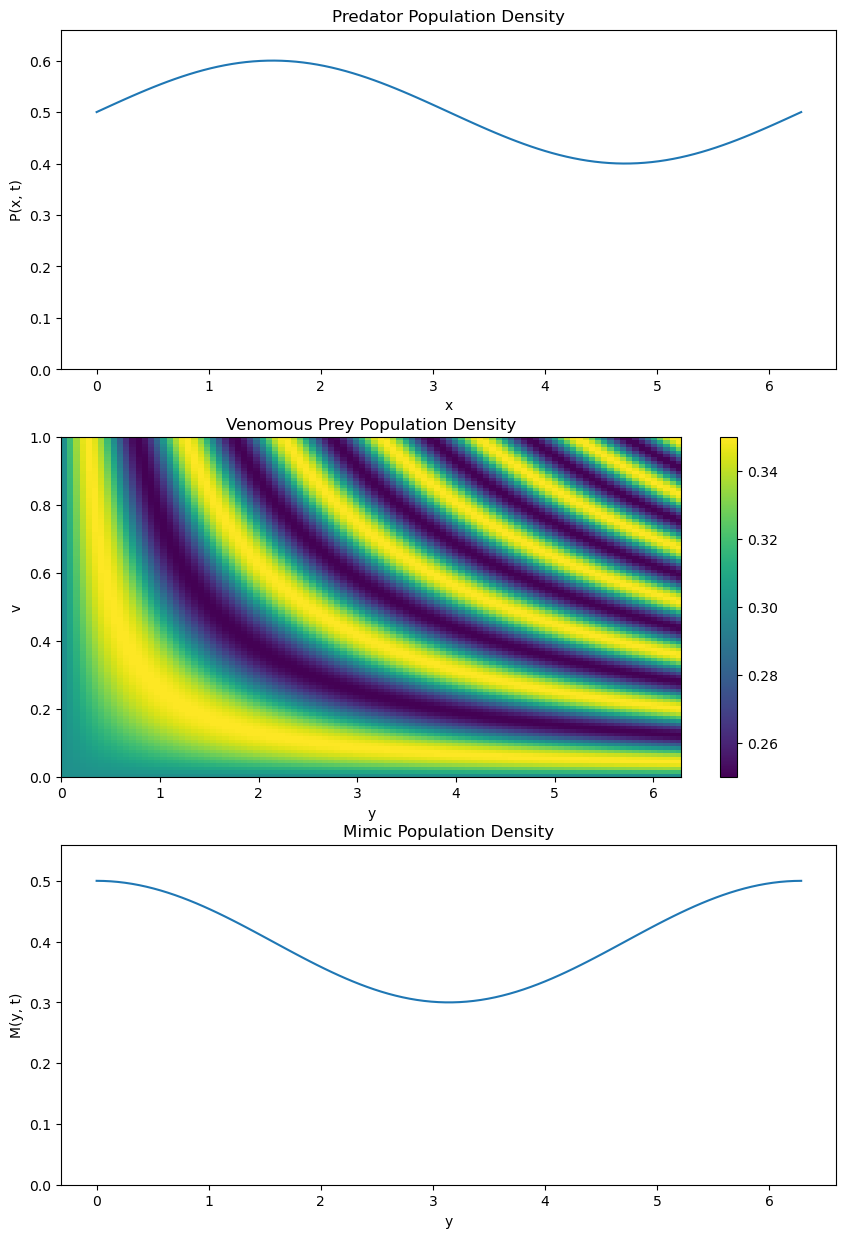

In [21]:
# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

line1, = ax1.plot(x, P[0])
ax1.set_ylim(0, np.max(P) * 1.1)
ax1.set_xlabel('x')
ax1.set_ylabel('P(x, t)')
ax1.set_title('Predator Population Density')

im2 = ax2.imshow(V[0], aspect='auto', extent=[0, L, 0, 1], origin='lower')
ax2.set_xlabel('y')
ax2.set_ylabel('v')
ax2.set_title('Venomous Prey Population Density')
plt.colorbar(im2, ax=ax2)

line3, = ax3.plot(x, M[0])
ax3.set_ylim(0, np.max(M) * 1.1)
ax3.set_xlabel('y')
ax3.set_ylabel('M(y, t)')
ax3.set_title('Mimic Population Density')

Text(0.5, 1.0, 'Mimic Population Density')

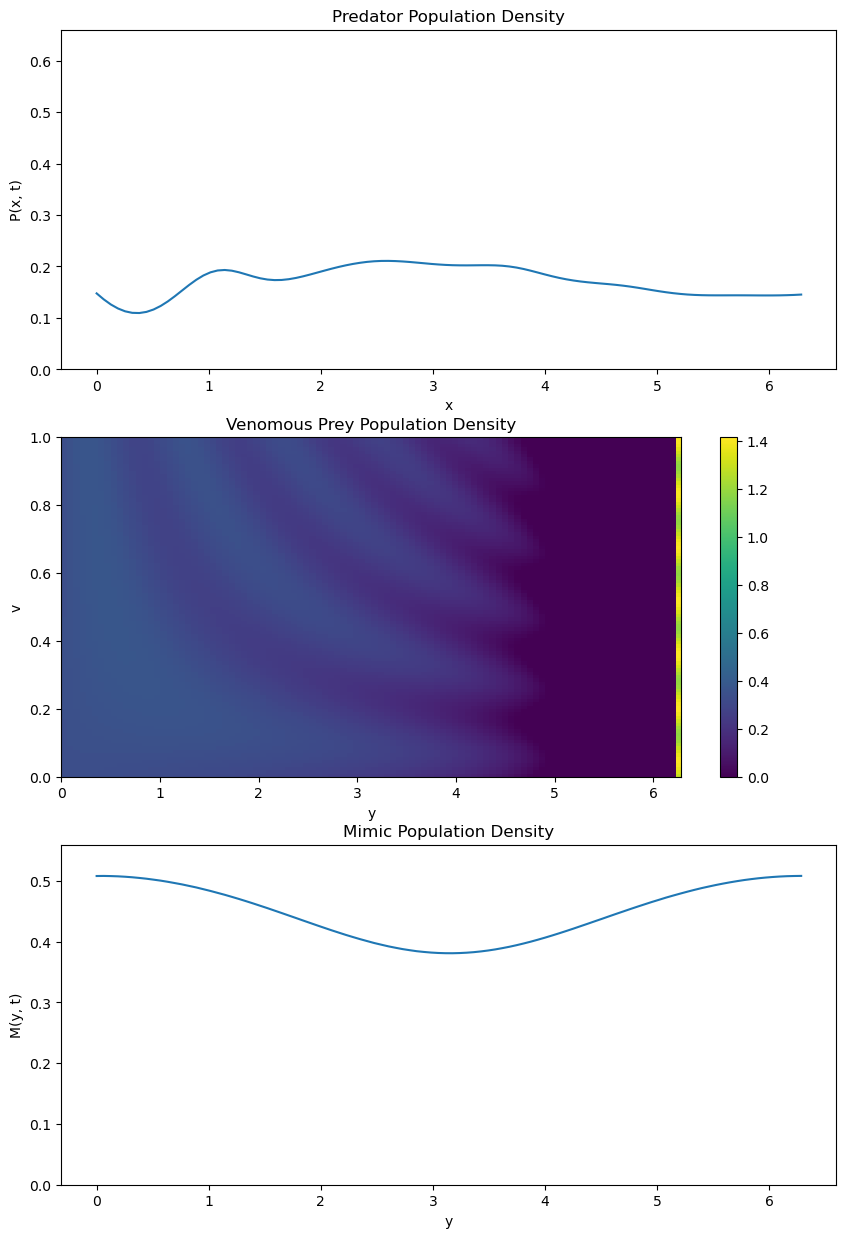

In [22]:
# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

line1, = ax1.plot(x, P[-1])
ax1.set_ylim(0, np.max(P) * 1.1)
ax1.set_xlabel('x')
ax1.set_ylabel('P(x, t)')
ax1.set_title('Predator Population Density')

im2 = ax2.imshow(V[-1], aspect='auto', extent=[0, L, 0, 1], origin='lower')
ax2.set_xlabel('y')
ax2.set_ylabel('v')
ax2.set_title('Venomous Prey Population Density')
plt.colorbar(im2, ax=ax2)

line3, = ax3.plot(x, M[-1])
ax3.set_ylim(0, np.max(M) * 1.1)
ax3.set_xlabel('y')
ax3.set_ylabel('M(y, t)')
ax3.set_title('Mimic Population Density')

In [15]:
from IPython.display import HTML

def update(frame):
    line1.set_ydata(P[frame])
    im2.set_array(V[frame])
    line3.set_ydata(M[frame])
    return line1, im2, line3

ani = FuncAnimation(fig, update, frames=range(0, len(t), 10), interval=50, blit=True)
plt.close()
ani.save('pde.gif')
HTML(ani.to_jshtml())

MovieWriter stderr:
Error writing trailer of pde.gif: Invalid argument


KeyboardInterrupt

